In [1]:
import numpy as np
import pandas as pd

# P1 Carga y Limpieza de datos

### 1- . Carga

In [2]:
def obtener_semana(week):
    week = str(week)
    # Traemos los dataframe
    all_info = pd.read_csv('./data/raw/w'+week +
                           '/metrocuadrado_all_w'+week+'.csv')
    all_info.drop_duplicates(inplace=True)
    furnished = pd.read_csv('./data/raw/w'+week +
                            '/metrocuadrado_furnished_w'+week+'.csv')
    furnished.drop_duplicates(inplace=True)

    # Merge que identifica furnished dentro de all_info
    df = pd.merge(all_info, furnished, on=['property_type|rent_type|location', 'details', 'url', 'surface', 'price'],
                  how='outer', indicator=True)
    df.rename(columns={'n_rooms_x': 'n_rooms', 'n_bath_x': 'n_bath',
                       'metrocuadrado_index_x': 'metro_cuadrado'}, inplace=True)

    # Indices que solo hay en furnished
    indices = df[df._merge == 'right_only'].index
    for i in indices:
        df.loc[i, 'n_rooms'] = df.loc[i, 'n_rooms_y']
        df.loc[i, 'n_bath'] = df.loc[i, 'n_bath_y']
        df.loc[i, 'metro_cuadrado'] = df.loc[i, 'metrocuadrado_index_y']

    # Dropeamos los _y
    df.drop(['n_rooms_y', 'n_bath_y', 'metrocuadrado_index_y'],
            axis=1, inplace=True)

    # Dropeamos los duplicados y reseatmos indice
    df.drop_duplicates(inplace=True)
    df.reset_index(drop=True, inplace=True)

    return df

In [3]:
def append_dataframes():
    week_list = range(13, 18)
    df = pd.DataFrame()

    for week in week_list:
        df = df.append(obtener_semana(week))

    df.drop_duplicates(inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

In [4]:
# Iniciar Data frame
df = append_dataframes()

Si hay furnished que no hay en all, identificados como 'right_only' de la columna _merge

### 2- . Limpieza

##### a)

In [5]:
# Limpiamos la columna price
df['price'] = df['price'].str.replace('$', '')
df['price'] = df['price'].str.replace('.', '')
df['price'] = df['price'].apply(float)

In [6]:
# Limpiamos la columna surface
df['surface'] = df['surface'].str.replace('m2', '')
df['surface'] = df['surface'].apply(float)

In [7]:
# Limpiamos n_rooms y n_baths, sujeto a cambios
#df['n_rooms'] = df['n_rooms'].replace('5+', 6)
#df['n_rooms'].fillna(3, inplace=True)


def transforma_int(num):
    if num == np.nan:
        return num
    elif num == 'nan':
        return np.nan
    elif num == '5+':
        return num
    else:
        return str(float(num))


df['n_rooms'] = df['n_rooms'].apply(transforma_int)

#df['n_bath'] = df['n_bath'].replace('5+', 6)
#df['n_bath'].fillna(3, inplace=True)
df['n_bath'] = df['n_bath'].apply(transforma_int)

Vemos los Dtype

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16379 entries, 0 to 16378
Data columns (total 9 columns):
property_type|rent_type|location    16379 non-null object
price                               16379 non-null float64
n_rooms                             16379 non-null object
n_bath                              16379 non-null object
surface                             16379 non-null float64
details                             16269 non-null object
url                                 16379 non-null object
metro_cuadrado                      16379 non-null float64
_merge                              16379 non-null category
dtypes: category(1), float64(3), object(5)
memory usage: 1.0+ MB


In [9]:
df['n_rooms'].unique()

array(['3.0', '5.0', '4.0', '2.0', '1.0', 'nan', '5+'], dtype=object)

##### b)

In [10]:
# Split de la comuna
s = pd.Series(df.keys())
split = s.str.split('|', expand=True)

# Columnas de transicion
df[['property_type+rent_type', 'location']
   ] = df['property_type|rent_type|location'].str.split(',', expand=True)
df[['property_type', 'rent_type']
   ] = df['property_type+rent_type'].str.split(' en ', expand=True)

# Dropeamos las extra
df = df.drop(['property_type|rent_type|location',
              'property_type+rent_type'], axis=1)

### 3- . Creación de columnas indicadoras

#### a)

In [11]:
# Creamos columna precio m2
df['precio_m2'] = df['price']/df['surface']

#### b)

In [12]:
def num_garajes(url):
    url_splitted = url.split('-garajes')
    # Si no hacemos split
    if len(url_splitted) == 1:
        return '0'
    else:
        # Agarramos las ultimos dos caracteres XX-garajes
        n = url_splitted[0][-2:]
        # Si es del tipo -1-garajes, devolvemos 1
        if n[0] == '-':
            return n[1]
        return str(n)


# Creamos la columna n_garajes
df['n_garajes'] = df['url'].apply(num_garajes)

In [13]:
# Limpiamos n_garajes, sujeto a cambios
#df['n_garajes'] = df['n_garajes'].replace('4+',5)
df['n_garajes'] = df['n_garajes'].apply(str)

In [14]:
df['n_garajes'].unique()

array(['1', '0', '2', '4', '3', '4+'], dtype=object)

### 4- . Clasificación por tipo de producto

In [15]:
# Inicializamos la columna tipo
df['tipo'] = np.nan


def clasifica_producto(df):
    # Areas
    area_min = [80, 120, 180, 240, 360, 40, 60, 80]
    area_max = [120, 180, 240, 360, 460, 60, 80, 120]

    # Query
    for tipo_prod in range(1, 9):
        minimo = area_min[tipo_prod-1]
        maximo = area_max[tipo_prod-1]
        # Query para tipos 1-5
        if tipo_prod < 6:
            query = 'property_type == "Casa" and {} < surface < {}'.format(
                minimo, maximo)
            indices = df.query(query).index
            for i in indices:
                df.loc[i, 'tipo'] = str(tipo_prod)
        else:
            query = 'property_type == "Apartamento" and {} < surface < {}'.format(
                minimo, maximo)
            indices = df.query(query).index
            for i in indices:
                df.loc[i, 'tipo'] = str(tipo_prod)

    return df


# Actualizamos el dataframe
df = clasifica_producto(df)

In [16]:
df['tipo'].unique()

array([nan, '1', '2', '3', '4', '5', '6', '7', '8'], dtype=object)

### 5- .

In [17]:
upz = pd.read_csv('./data/asignacion_upz/barrio-upz.csv')

In [18]:
def transforma_str(elemento):
    if type(elemento) == str:
        espaciado = elemento.strip()
        if len(espaciado) != 0:
            return elemento
    else:
        return '-nulo-'


upz['pro_location'] = upz['pro_location'].apply(transforma_str)
upz['pro_location'] = upz['pro_location'].apply(str.upper)

In [19]:
# Inicializamos la columna
df['upz'] = np.nan
df['UPlArea'] = np.nan


def clasifica_upz(df):
    locaciones = list(upz['pro_location'])
    upl_area = list(upz['UPlArea'])
    codigos_upl = list(upz['UPlCodigo'])

    for area, codigo, locacion in zip(upl_area, codigos_upl, locaciones):
        indice = df[df['location'].str.contains(locacion)].index

        for i in indice:
            df.loc[i, 'upz'] = codigo
            df.loc[i, 'UPlArea'] = area

    return df


df = clasifica_upz(df)

In [20]:
df.head(3)

,price,n_rooms,n_bath,surface,details,url,metro_cuadrado,_merge,location,property_type,rent_type,precio_m2,n_garajes,tipo,upz,UPlArea
0,1050000.0,3.0,2.0,63.0,Excelente casa cerca de la calle 80 y Avenida ...,https://www.metrocuadrado.com/inmueble/arriend...,25.6,left_only,LA SOLEDAD NORTE Bogotá D.C..,Casa,Arriendo,16666.666667,1,NaN,UPZ101,2.357008e+06
1,3930000.0,3.0,2.0,100.0,Se arrienda casa bonita totalmente amoblada co...,https://www.metrocuadrado.com/inmueble/arriend...,57.3,both,CIUDAD SALITRE SUR-ORIENTAL Bogotá D.C..,Casa,Arriendo,39300.000000,1,1,NaN,NaN
2,750000.0,3.0,1.0,90.0,CASA DE TRES NIVELES TRES ALCOBAS SALA COMEDOR...,https://www.metrocuadrado.com/inmueble/arriend...,12.2,left_only,VILLA DE LOS ALPES II SECTOR Bogotá D.C..,Casa,Arriendo,8333.333333,0,1,UPZ75,4.964574e+06


In [21]:
print('Porcentaje de objetos con código UPZ')
len(df[df['upz'].notna()])/len(df) * 100

Porcentaje de objetos con código UPZ


91.88595152329202

### 6- .

In [22]:
est_poblacion = pd.read_csv(
    './data/estadisticas_upz/estadisticas_poblacion.csv')
est_poblacion.drop(columns=['Unnamed: 0', 'nomupz'], inplace=True)
est_poblacion.head()

,upz,personas,trabajoinf_ninos_5_17_anos_perc,trabajoinfampliado_ninos_5_17_anos_perc,jovenes_14_24_anos_nini_perc,indice_envegecimiento,jefe_mujer_perc,adultos_mayores_pobres_perc
0,UPZ11,68430,0.6,3.9,20.7,35.2,44.579934,17.931973
1,UPZ12,50037,1.8,16.7,9.1,54.7,36.279630,5.420442
2,UPZ13,102981,0.0,3.5,5.5,118.4,33.286852,3.250000
3,UPZ18,69961,0.4,7.2,9.4,42.7,36.465059,9.439051
4,UPZ19,121158,0.3,8.0,8.2,59.1,32.887202,5.406574


In [23]:
# Enriquecemos df con los datos de est_poblacion
df = df.merge(est_poblacion, on='upz', how='left')

In [24]:
ind_inseg = pd.read_csv('./data/estadisticas_upz/indice_inseguridad.csv')
ind_inseg = ind_inseg.rename(columns={'UPlCodigo': 'upz'})
ind_inseg.drop(columns=['UPlNombre2', 'Unnamed: 0'], inplace=True)
ind_inseg.head()

,upz,indice_inseguridad
0,UPZ100,0.671141
1,UPZ83,0.000000
2,UPZ107,2.318841
3,UPZ101,3.629032
4,UPZ91,13.537118


In [25]:
# Enriquecemos df con el indice de inseguridad
df = df.merge(ind_inseg, on='upz', how='left')

In [26]:
per_areas_verdes = pd.read_csv(
    './data/estadisticas_upz/porcentaje_areas_verdes.csv')
per_areas_verdes.head()

,Unnamed: 0,cod_upz,upz,areas_verdes_perc
0,0,51.0,Los Libertadores,58.196667
1,1,87.0,Tintal Sur,85.924848
2,2,1.0,Paseo de los Libertadores,83.966495
3,3,64.0,Monte Blanco,85.778144
4,4,29.0,Minuto de Dios,37.852289


In [27]:
per_areas_verdes.rename(
    columns={'upz': 'zona', 'cod_upz': 'upz'}, inplace=True)
per_areas_verdes['upz'] = per_areas_verdes['upz'].astype(int)
per_areas_verdes['upz'] = per_areas_verdes['upz'].astype(str)
per_areas_verdes['upz'] = per_areas_verdes['upz'].apply(lambda num: 'UPZ'+num)
per_areas_verdes['upz'] = per_areas_verdes['upz'].apply(str.upper)
per_areas_verdes.drop(columns=['Unnamed: 0'], inplace=True)
per_areas_verdes.head()

,upz,zona,areas_verdes_perc
0,UPZ51,Los Libertadores,58.196667
1,UPZ87,Tintal Sur,85.924848
2,UPZ1,Paseo de los Libertadores,83.966495
3,UPZ64,Monte Blanco,85.778144
4,UPZ29,Minuto de Dios,37.852289


In [28]:
# Enriquecemos df con el porcentaje de areas verdes
df = df.merge(per_areas_verdes, on='upz', how='left')
df.head(3)

,price,n_rooms,n_bath,surface,details,url,metro_cuadrado,_merge,location,property_type,...,personas,trabajoinf_ninos_5_17_anos_perc,trabajoinfampliado_ninos_5_17_anos_perc,jovenes_14_24_anos_nini_perc,indice_envegecimiento,jefe_mujer_perc,adultos_mayores_pobres_perc,indice_inseguridad,zona,areas_verdes_perc
0,1050000.0,3.0,2.0,63.0,Excelente casa cerca de la calle 80 y Avenida ...,https://www.metrocuadrado.com/inmueble/arriend...,25.6,left_only,LA SOLEDAD NORTE Bogotá D.C..,Casa,...,19451.0,0.6,18.4,7.2,145.7,44.896230,5.281135,3.629032,Teusaquillo,6.563105
1,3930000.0,3.0,2.0,100.0,Se arrienda casa bonita totalmente amoblada co...,https://www.metrocuadrado.com/inmueble/arriend...,57.3,both,CIUDAD SALITRE SUR-ORIENTAL Bogotá D.C..,Casa,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,750000.0,3.0,1.0,90.0,CASA DE TRES NIVELES TRES ALCOBAS SALA COMEDOR...,https://www.metrocuadrado.com/inmueble/arriend...,12.2,left_only,VILLA DE LOS ALPES II SECTOR Bogotá D.C..,Casa,...,179732.0,0.4,1.2,14.5,45.4,31.113458,14.928786,0.310559,Fontibón,21.756250


In [29]:
# Enriquecemos df con la densidad de población por UPZ
df['dens_upz'] = df['personas']/df['UPlArea']

In [30]:
df.replace(np.inf, np.nan, inplace=True)
df.replace(-np.inf, np.nan, inplace=True)
df['_merge'] = df['_merge'].astype(str)
# df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16381 entries, 0 to 16380
Data columns (total 27 columns):
price                                      16381 non-null float64
n_rooms                                    16381 non-null object
n_bath                                     16381 non-null object
surface                                    16381 non-null float64
details                                    16271 non-null object
url                                        16381 non-null object
metro_cuadrado                             16381 non-null float64
_merge                                     16381 non-null object
location                                   16381 non-null object
property_type                              16381 non-null object
rent_type                                  16381 non-null object
precio_m2                                  16365 non-null float64
n_garajes                                  16381 non-null object
tipo                                      

In [31]:
# Copia para correr P2
copia = df.copy()

# P2

In [32]:
df = copia

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from scipy import stats

## Parte 1

In [34]:
def estilo():
    sns.set_style('dark')
    sns.despine()

## Parte 2

In [35]:
names = ['numeric', 'categorical', 'resto']
# Se crea una lista con las columnas numericas
numeric = ['price', 'surface', 'metro_cuadrado', 'precio_m2',
           'UPlArea', 'personas', 'trabajoinf_ninos_5_17_anos_perc',
           'trabajoinfampliado_ninos_5_17_anos_perc',
           'jovenes_14_24_anos_nini_perc', 'indice_envegecimiento',
           'jefe_mujer_perc', 'adultos_mayores_pobres_perc', 'indice_inseguridad',
           'areas_verdes_perc', 'dens_upz'
           ]

# datos no categoricos ni numerico
resto = ['details','zona', 'location','url']

# Se crea una lista con las columnas categoricas
categorical = list(set(df.columns) - set(numeric) - set(resto))


mapping = [('numeric', col) for col in numeric]
mapping.extend([('categorical', col) for col in categorical])
'''
Se reordenan las columnas del dataframe para que coincidan con el esquema 
del multi indice
'''

df = df.reindex(columns=numeric + categorical)

In [36]:
# Se reasignan las columnas
df.columns = pd.MultiIndex.from_tuples(mapping)

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16381 entries, 0 to 16380
Data columns (total 23 columns):
(numeric, price)                                      16381 non-null float64
(numeric, surface)                                    16381 non-null float64
(numeric, metro_cuadrado)                             16381 non-null float64
(numeric, precio_m2)                                  16365 non-null float64
(numeric, UPlArea)                                    15052 non-null float64
(numeric, personas)                                   15052 non-null float64
(numeric, trabajoinf_ninos_5_17_anos_perc)            15052 non-null float64
(numeric, trabajoinfampliado_ninos_5_17_anos_perc)    15052 non-null float64
(numeric, jovenes_14_24_anos_nini_perc)               15052 non-null float64
(numeric, indice_envegecimiento)                      15052 non-null float64
(numeric, jefe_mujer_perc)                            15052 non-null float64
(numeric, adultos_mayores_pobres_perc)      

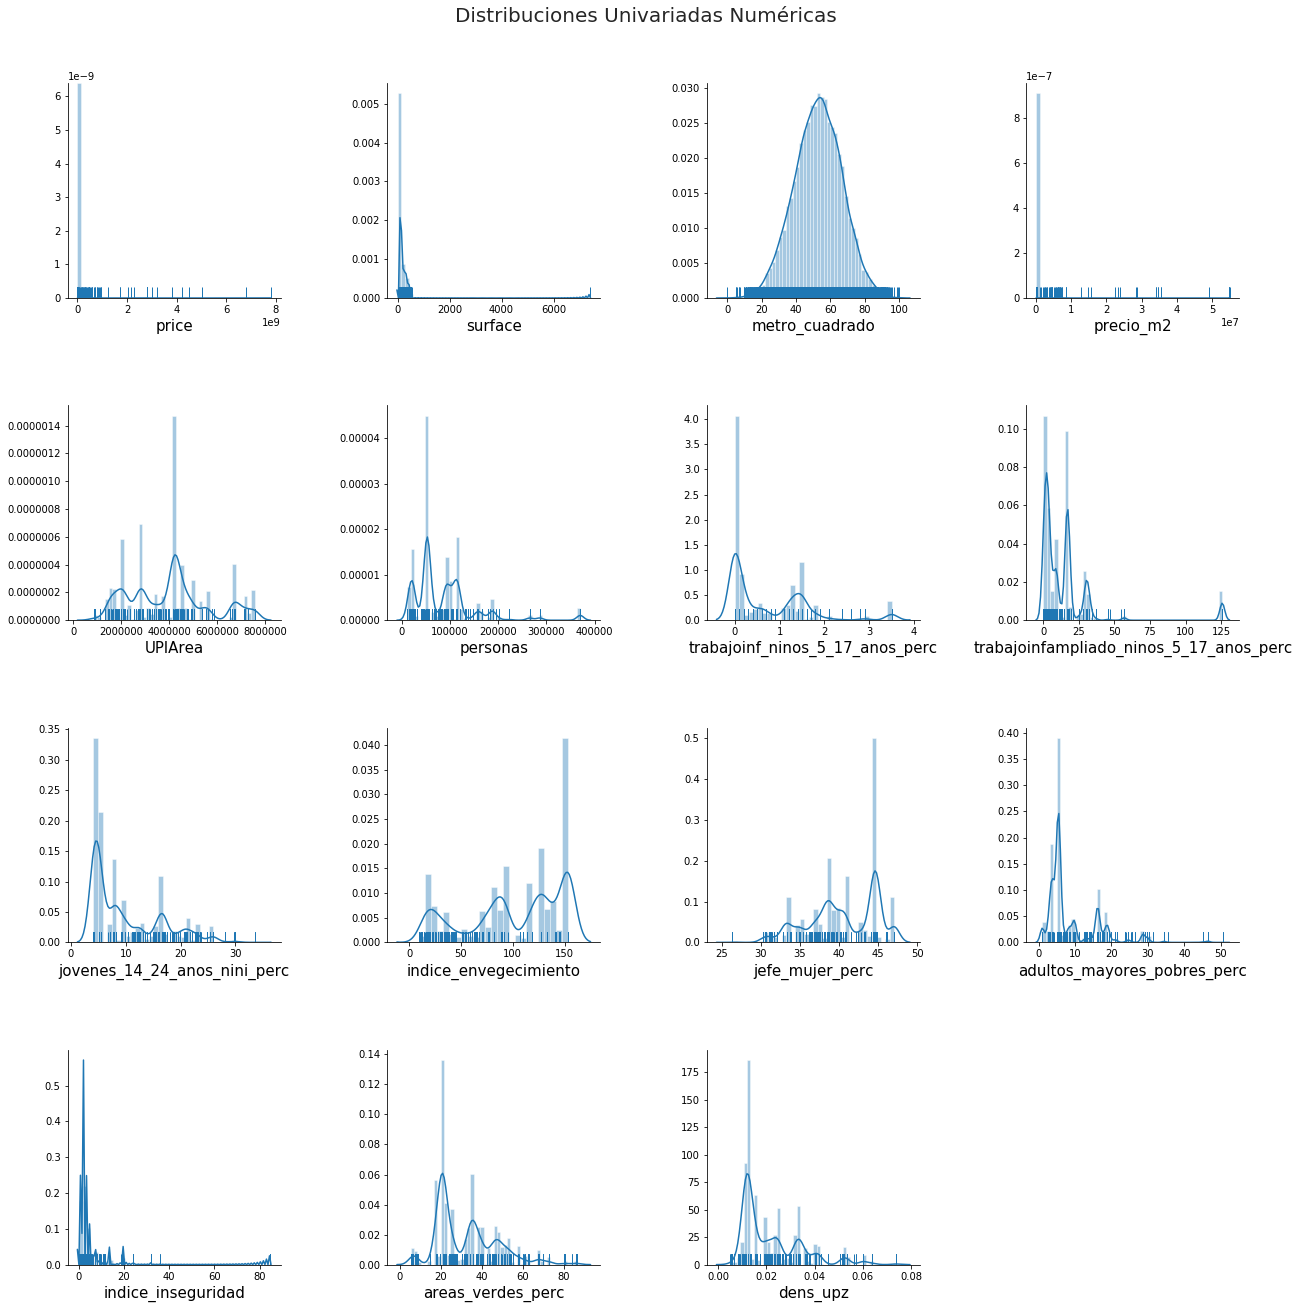

In [38]:
# Grilla de subplots
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=[17, 17])
estilo()

# Se remueven el ultimo plot
list(map(lambda a: a.remove(), ax[-1, -1:]))

# Se ajusta el espaciado exterior de la figura
fig.tight_layout()

# Se define un titulo y su ubicacion
fig.suptitle('Distribuciones Univariadas Numéricas',
             fontsize=20,
             x=0.5,
             y=1.05)
'''
Se recorre cada axis, para cada columna del dataframe, se genera un grafico 
distinto en funcion del tipo de dato.

'''
for axis, col in zip(ax.flatten(), numeric):
    # print(col)
    try:
        # Graficos para datos numericos
        sns.distplot(df[('numeric', col)].dropna(), ax=axis, rug=True)

    except RuntimeError:
        sns.distplot(df[('numeric', col)].dropna(),
                     ax=axis, rug=True, kde=False)

    axis.set_xlabel(col, fontsize=15)

# Se ajusta el espaciado interno entre subplots
w, h = (.5, 0.5)
plt.subplots_adjust(wspace=w, hspace=h)
plt.show()

La variable metro_cuadrado es de gran interés por su normalidad. precio y precio_m2 tienen gran cantidad de outliers que empeora su perfilamiento.

In [39]:
# Notemos que hay ciertas variables que al considerar menos datos, mejora la densidad
num_antes = len(df)
#df = df[df[('numeric','surface')] <= 4 * 10**3]
#df = df[df[('numeric','precio_m2')] <= 2 * 10**5]
df = df[df[('numeric','surface')] <= 10000]
df = df[df[('numeric','precio_m2')] <= 100000]
#df = df[df[('numeric','indice_inseguridad')] <= 80]
df.reset_index(drop=True, inplace = True)
num_despues = len(df)
print('Se dropearon',num_antes-num_despues,'elementos')

Se dropearon 100 elementos


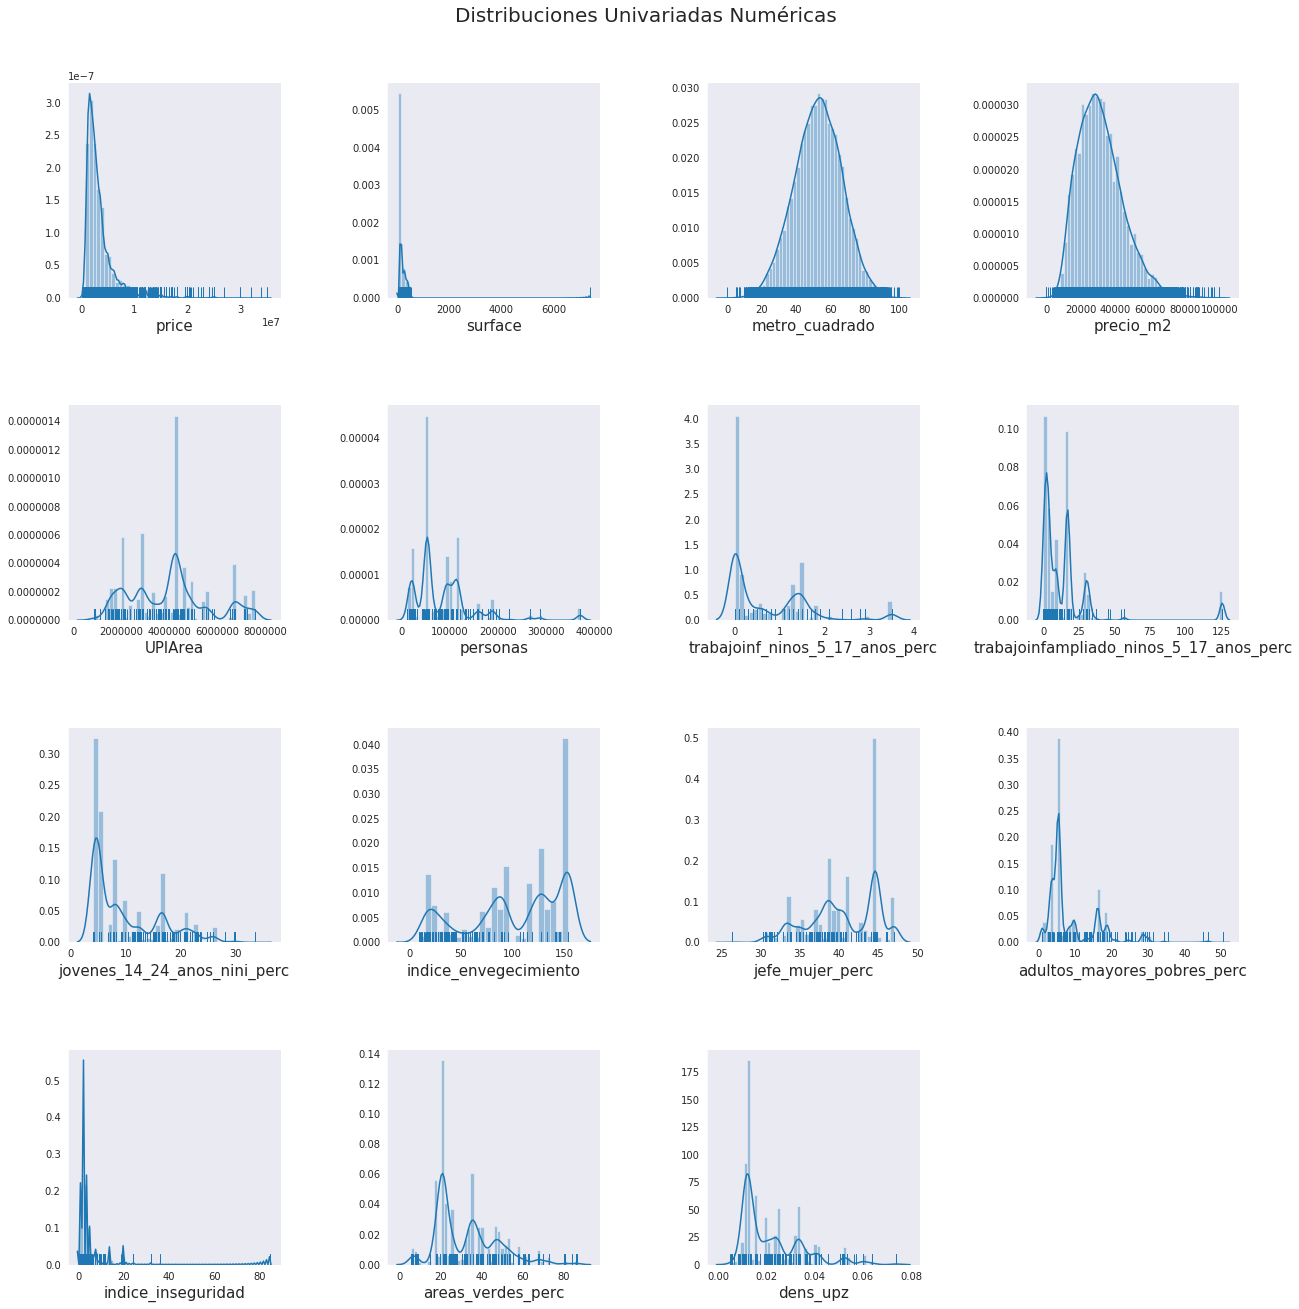

In [40]:
# Grilla de subplots
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=[17, 17])
estilo()

# Se remueven el ultimo plot
list(map(lambda a: a.remove(), ax[-1, -1:]))

# Se ajusta el espaciado exterior de la figura
fig.tight_layout()

# Se define un titulo y su ubicacion
fig.suptitle('Distribuciones Univariadas Numéricas',
             fontsize=20,
             x=0.5,
             y=1.05)
'''
Se recorre cada axis, para cada columna del dataframe, se genera un grafico 
distinto en funcion del tipo de dato.

'''
for axis, col in zip(ax.flatten(), numeric):
    # print(col)
    try:
        # Graficos para datos numericos
        sns.distplot(df[('numeric', col)].dropna(), ax=axis, rug=True)

    except RuntimeError:
        sns.distplot(df[('numeric', col)].dropna(),
                     ax=axis, rug=True, kde=False)

    axis.set_xlabel(col, fontsize=15)

# Se ajusta el espaciado interno entre subplots
w, h = (.5, 0.5)
plt.subplots_adjust(wspace=w, hspace=h)
plt.show()

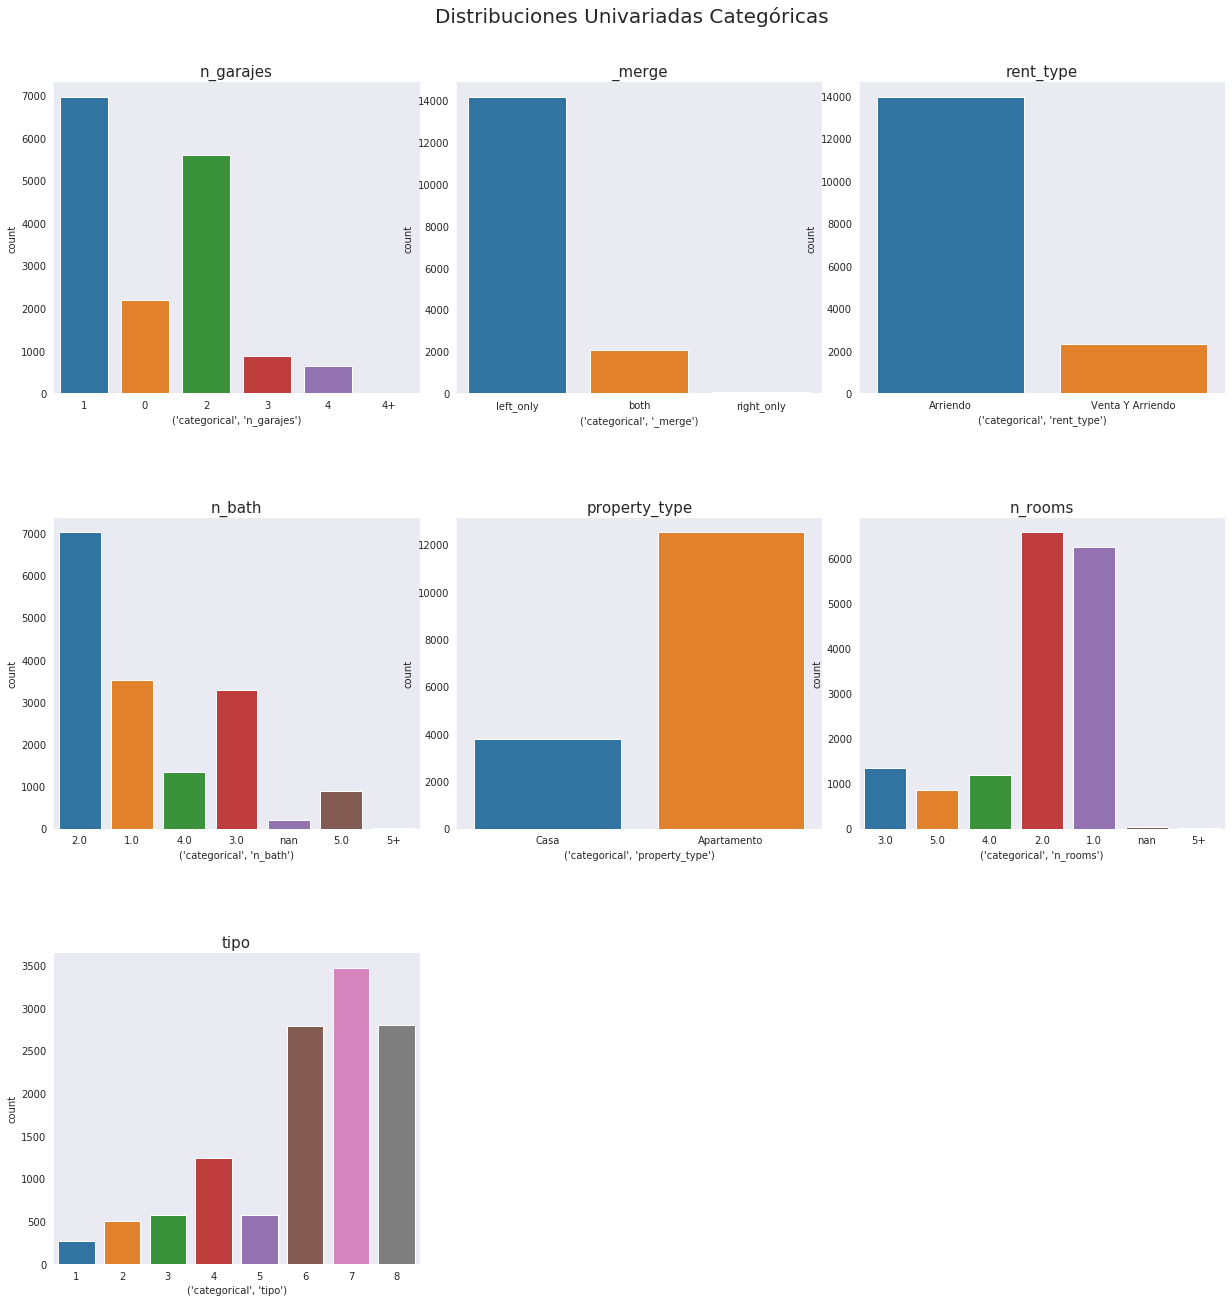

In [41]:
# distribucion de datos categoricos
# Grilla de subplots
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=[17, 17])


list(map(lambda a: a.remove(), ax[-1, -2:]))

# Se ajusta el espaciado exterior de la figura
fig.tight_layout()

# Se define un titulo y su ubicacion
fig.suptitle('Distribuciones Univariadas Categóricas',
             fontsize=20,
             x=0.5,
             y=1.05)
cat_not_url=[cat for cat in categorical if ((cat!='url') & (cat!='upz') )]

for axis, col in zip(ax.flatten(), cat_not_url):

    # Graficos para datos tipos str
    sns.countplot(df[('categorical',col)], ax=axis)
    #axis.set_axis_off()
    axis.set_title(col, fontsize=15)
    estilo()
  
    
# Se ajusta el espaciado interno entre subplots
h, w = (.4, .1)
plt.subplots_adjust(wspace=w, hspace=h)



In [42]:
# Datos faltantes
import missingno as msno
#df.replace('nan', np.nan, inplace=True)
print('Valores nan')
print(df.isnull().sum())
print('Mayor info perdida')
print(df.isnull().sum().nlargest(10))

Valores nan
numeric      price                                         0
             surface                                       0
             metro_cuadrado                                0
             precio_m2                                     0
             UPlArea                                    1325
             personas                                   1325
             trabajoinf_ninos_5_17_anos_perc            1325
             trabajoinfampliado_ninos_5_17_anos_perc    1325
             jovenes_14_24_anos_nini_perc               1325
             indice_envegecimiento                      1325
             jefe_mujer_perc                            1325
             adultos_mayores_pobres_perc                1325
             indice_inseguridad                         1325
             areas_verdes_perc                          1325
             dens_upz                                   1325
categorical  n_garajes                                     0
            

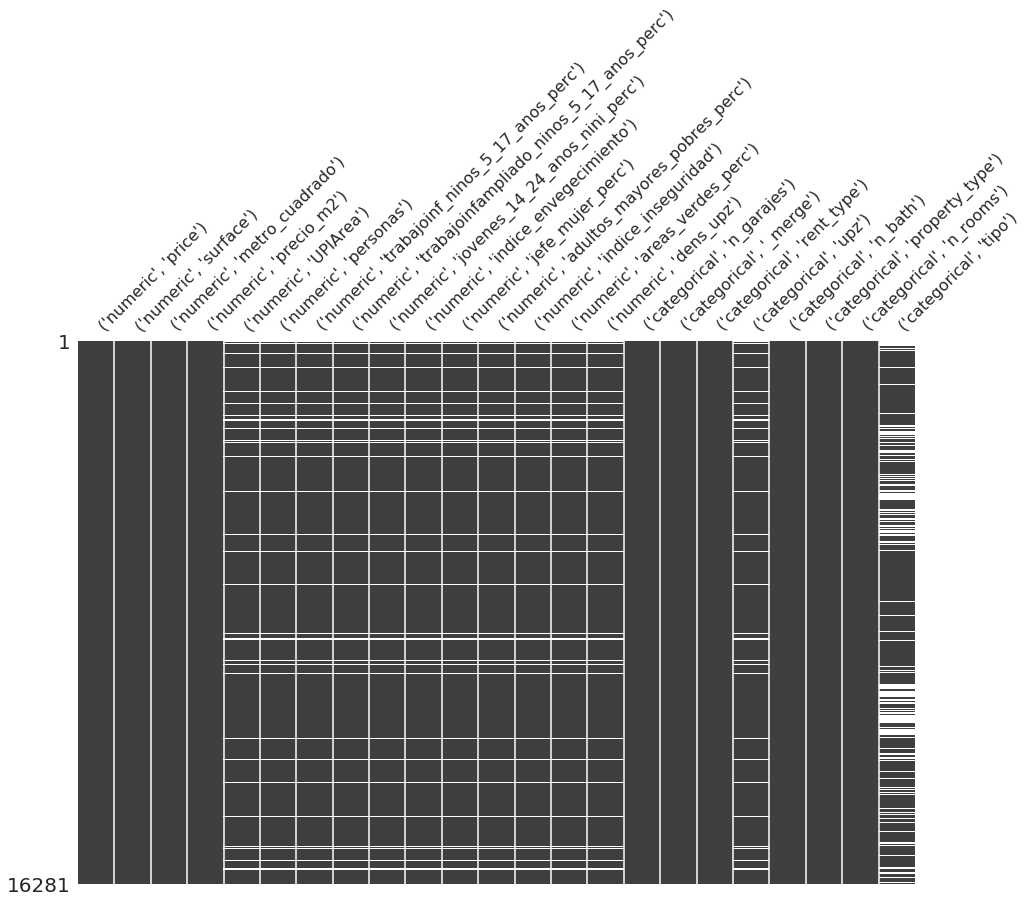

In [43]:
fig, ax = plt.subplots(figsize=[15, 10])
msno.matrix(df, ax=ax, sparkline=False)

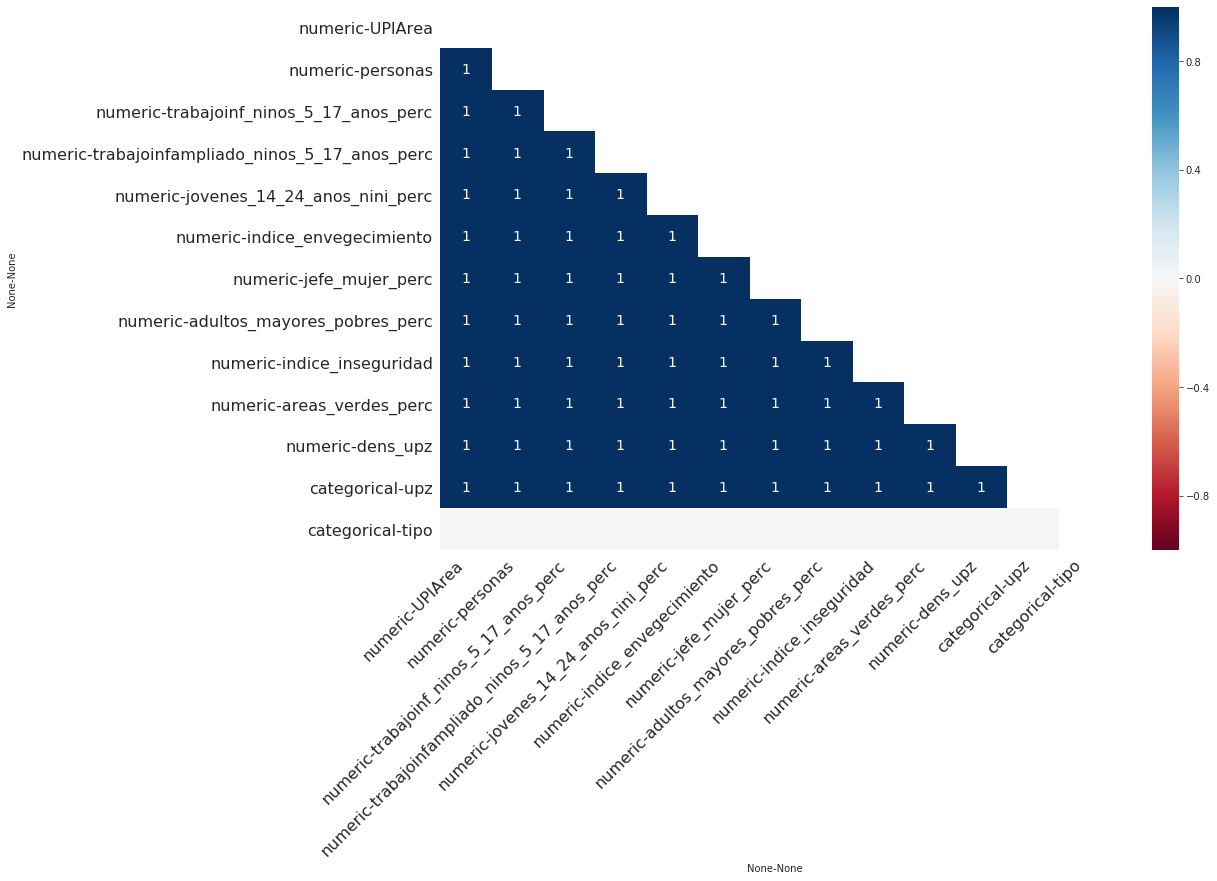

In [44]:
# Correlaciones de nulidad entre pares de variables
fig, ax = plt.subplots(figsize=[15, 10])
msno.heatmap(df, ax=ax)

In [45]:
largest_nulls = df.isnull().sum().nlargest(20)

In [46]:
nulls = df[largest_nulls.index]

In [47]:
nulls

categorical       numeric                                            \
             tipo       UPlArea  personas trabajoinf_ninos_5_17_anos_perc   
0             NaN  2.357008e+06   19451.0                             0.6   
1               1           NaN       NaN                             NaN   
2               1  4.964574e+06  179732.0                             0.4   
3             NaN  3.732645e+06  156375.0                             1.1   
4               1  2.906631e+06   50037.0                             1.8   
5             NaN  6.529011e+06  158990.0                             0.4   
6             NaN  3.732645e+06  156375.0                             1.1   
7               1           NaN       NaN                             NaN   
8             NaN  7.565953e+06   93195.0                             1.3   
9               1  7.565953e+06   93195.0                             1.3   
10              1  7.565953e+06   93195.0                             1.3   
11            NaN  4.586983e+06  115124.0                             1.5   
12              1  4.926920e+06  115124.0                             1.5   
13            NaN  3.809694e+06  106843.0                             1.3   
14            NaN  4.382732e+06   66427.0                             0.2   
15            NaN  4.334034e+06  121158.0                             0.3   
16              1           NaN       NaN                             NaN   
17              1  3.286562e+06   69961.0                             0.4   
18              1  3.085798e+06   90943.0                             0.0   
19            NaN           NaN       NaN                             NaN   
20            NaN  6.529011e+06  158990.0                             0.4   
21            NaN  4.382732e+06   66427.0                             0.2   
22            NaN  5.550407e+06  148791.0                             0.2   
23              1           NaN       NaN                             NaN   
24              1  4.776034e+06   24897.0                             0.1   
25            NaN  5.031966e+06  166766.0                             1.3   
26              1  1.799021e+06   92200.0                             1.1   
27            NaN  7.565953e+06   93195.0                             1.3   
28              1  7.565953e+06   93195.0                             1.3   
29              1  7.565953e+06   93195.0                             1.3   
...           ...           ...       ...                             ...   
16251         NaN  2.375681e+06   24215.0                             2.9   
16252           6  2.856068e+06  115124.0                             1.5   
16253           6  2.060243e+06   22440.0                             0.2   
16254         NaN  2.375681e+06   24215.0                             2.9   
16255         NaN  6.722632e+06  102981.0                             0.0   
16256         NaN  2.375681e+06   24215.0                             2.9   
16257         NaN  1.593025e+06   53837.0                             0.0   
16258           6  1.593025e+06   53837.0                             0.0   
16259           6  8.532359e+05   11570.0                             1.8   
16260         NaN  1.593025e+06   53837.0                             0.0   
16261           6  1.467630e+06   17226.0                             3.5   
16262         NaN  3.372134e+06  137082.0                             0.6   
16263           6  1.786034e+06   95541.0                             1.5   
16264         NaN  2.847741e+06   91513.0                             0.0   
16265           6  1.786034e+06   95541.0                             1.5   
16266           6  5.374763e+06  112706.0                             1.8   
16267           6  5.374763e+06  112706.0                             1.8   
16268           6           NaN       NaN                             NaN   
16269           6  4.926920e+06  115124.0                             1.5   
16

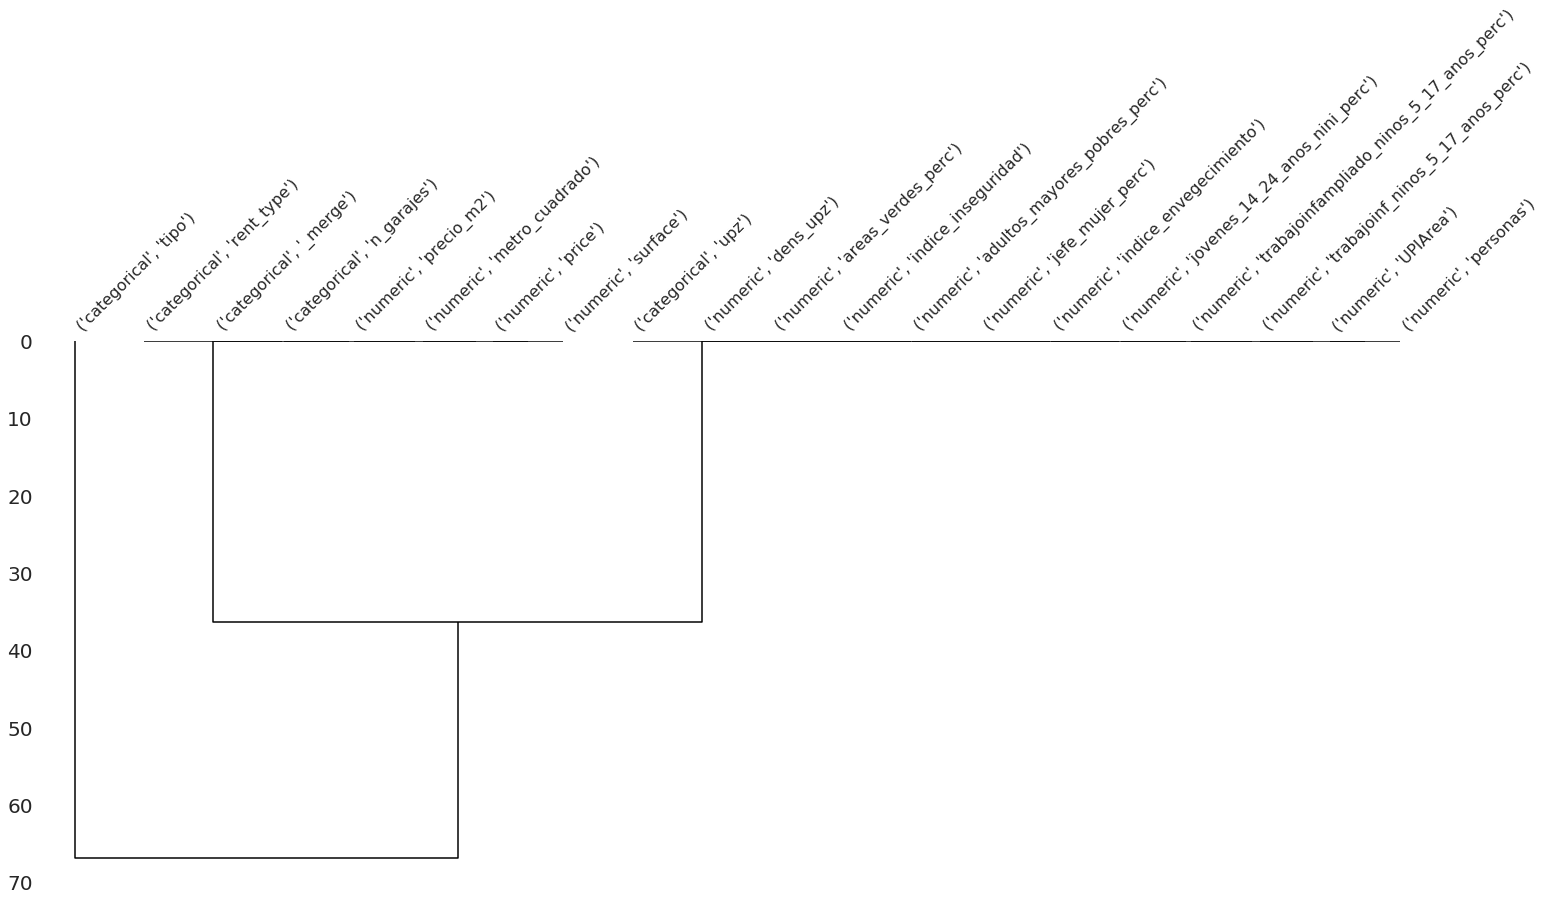

In [48]:
msno.dendrogram(nulls)

In [49]:
# dropear no mas
#df = df.copy()
#df.dropna(inplace=True)

In [50]:
# dropear precio cero
# df.drop(df.loc[df.numeric.precio_m2==0].index)

In [51]:
# Eliminar filas con datos faltantes que no contienen datos de UPZ, son MNAR
# creo q los tipos tambien, ya que son inclasificables

# en cambio, n_rooms baths y garajes estan todos en un cluster, esos son perdidos de otra info,
# podriamos reemplazar por ceil(promedio) o algo asi
df = df.copy()
df.dropna(inplace=True)

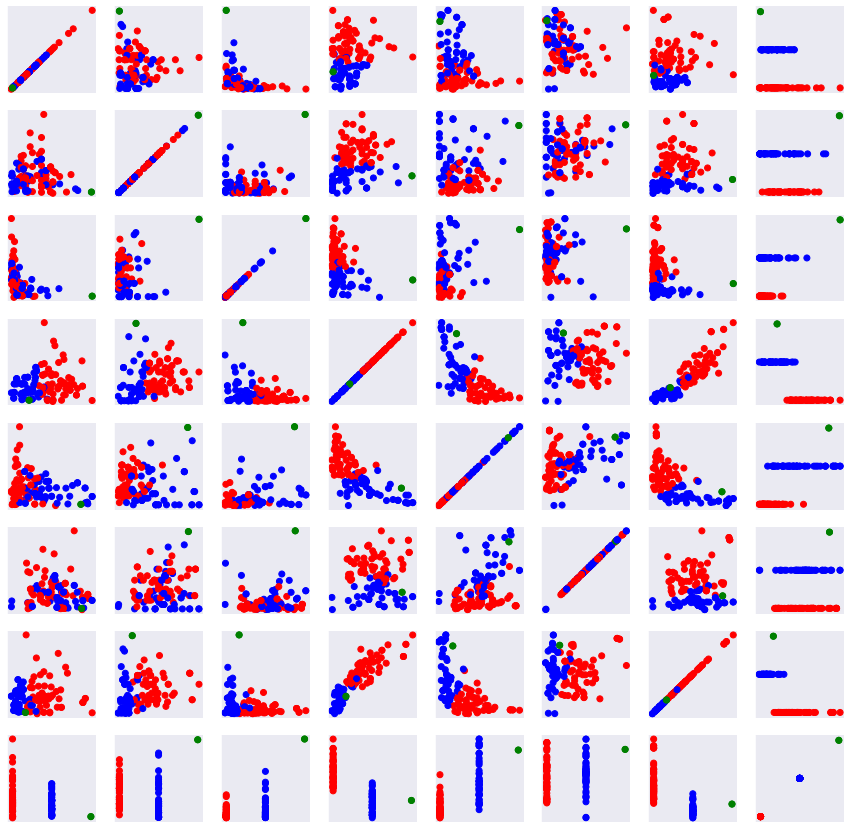

In [52]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

X1=est_poblacion.drop(columns=['upz'])
X1.index=est_poblacion.upz
n_clu=3
kmeans=KMeans(n_clusters=n_clu).fit_predict(scaler.fit_transform(X1))
X1['clusters_upz']=kmeans

assignator= lambda upz: str(X1.loc[upz]['clusters_upz'])

df[('categorical','upz_group')]=df.categorical.upz.apply(assignator)

n_com=len(X1.keys())
fig, axes =plt.subplots(n_com,n_com,figsize=(15,15))
fig.suptitle('')
colormap=np.array(['r','blue','green'])
for i in range(n_com):
    for j in range(n_com):
        axes[i,j].scatter(X1[X1.keys()[i]],X1[X1.keys()[j]],c=colormap[kmeans])
        axes[i,j].set_xticks([])
        axes[i,j].set_yticks([])
        estilo()
plt.show()

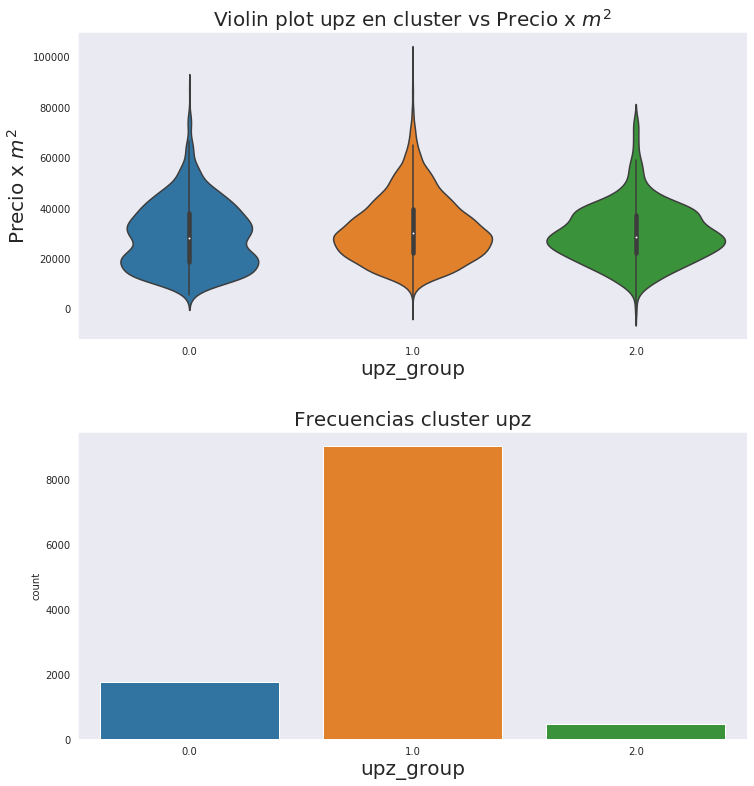

In [53]:
def violin_and_frec_plot(categorical_variable, title1, title2):
    fontdict = {'fontsize': 20}
    fig, ax = plt.subplots(2, 1, figsize=[12, 13])
    sns.violinplot(('categorical', categorical_variable),
                   y=('numeric', 'precio_m2'),
                   data=df,
                   kind='violin',
                   ax=ax[0])
    sns.countplot(df[('categorical', categorical_variable)], ax=ax[1])
    ax[0].set_xlabel(categorical_variable, fontdict)
    ax[1].set_xlabel(categorical_variable, fontdict)
    # ax[0].set_ylim(0,1000000)
    ax[0].set_ylabel(r'Precio x $m^2$', fontdict)
    ax[0].set_title(title1, fontdict)
    ax[1].set_title(title2, fontdict)
    h, w = (.3, .1)
    plt.subplots_adjust(wspace=w, hspace=h)


violin_and_frec_plot(
    'upz_group', 'Violin plot upz en cluster vs Precio x $m^2$', 'Frecuencias cluster upz')

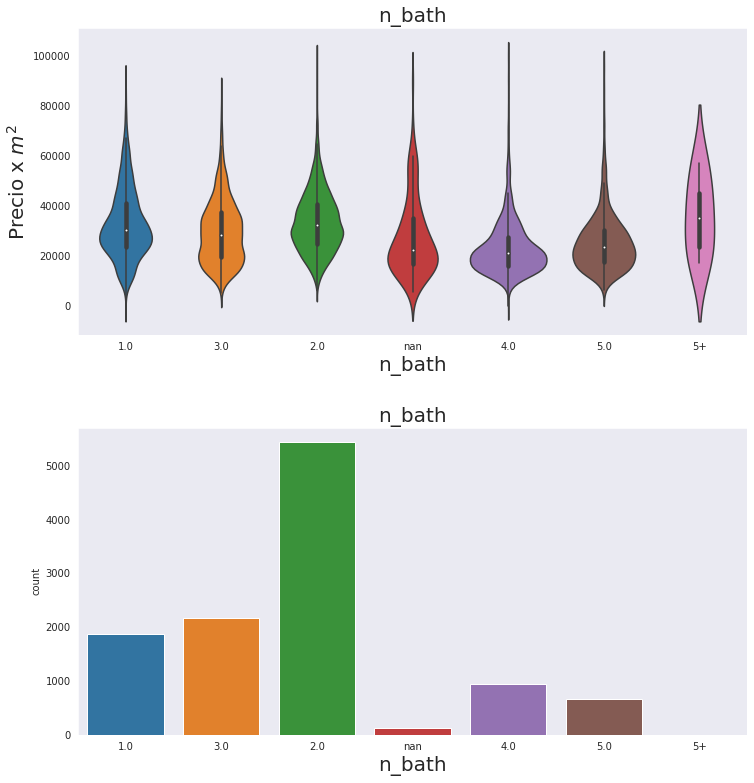

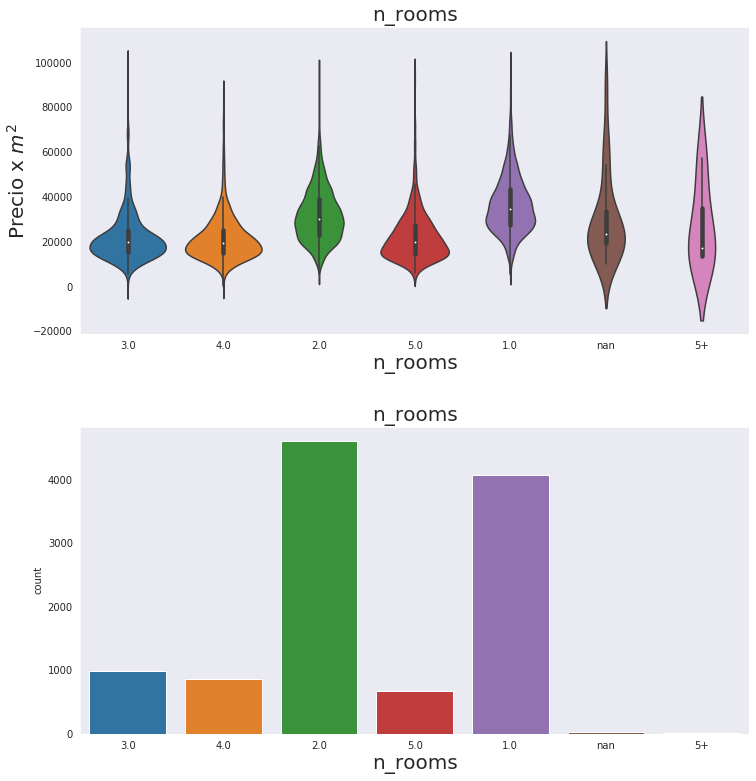

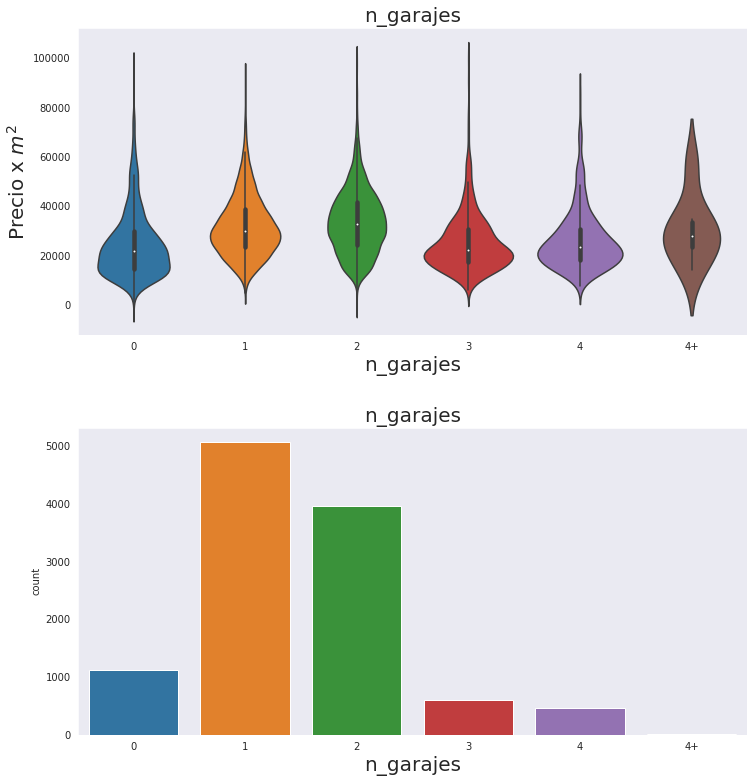

In [54]:
violin_and_frec_plot('n_bath', 'n_bath', 'n_bath')
violin_and_frec_plot('n_rooms', 'n_rooms', 'n_rooms')
violin_and_frec_plot('n_garajes', 'n_garajes', 'n_garajes')

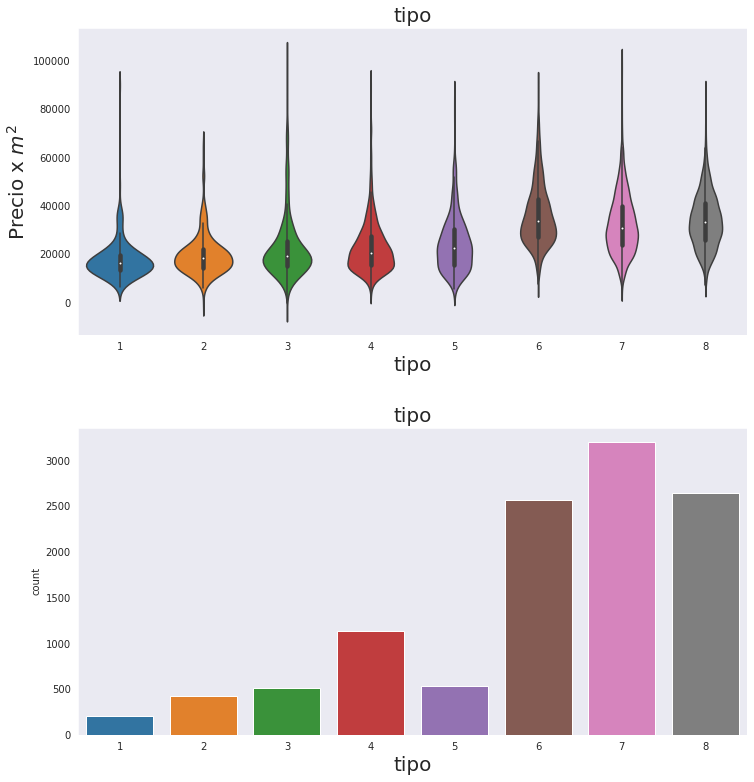

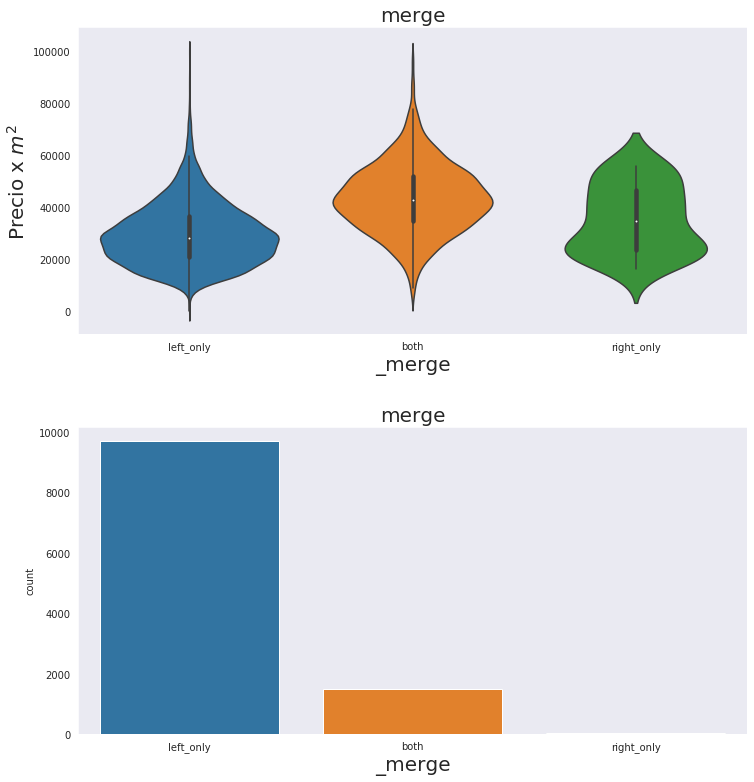

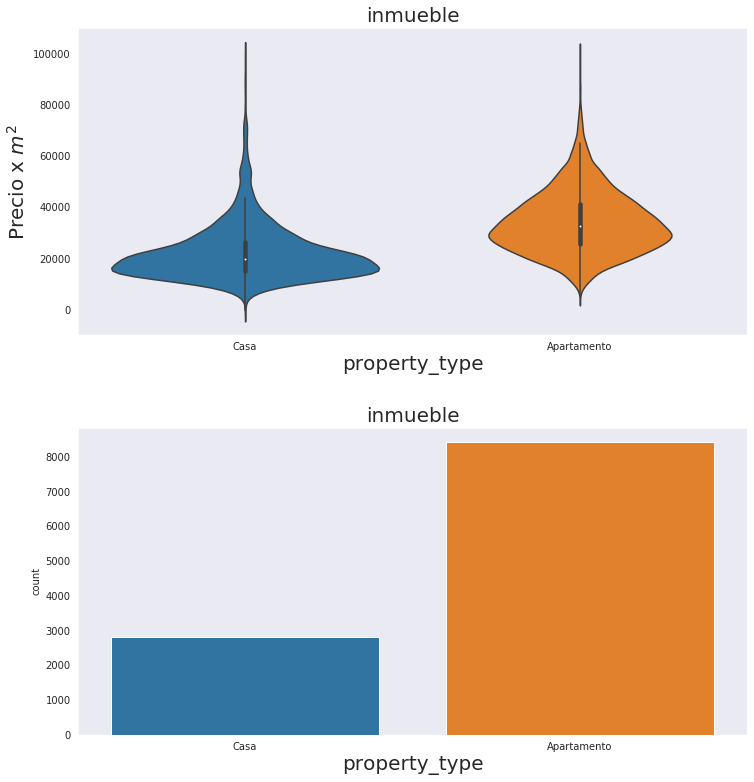

In [55]:
violin_and_frec_plot('tipo', 'tipo', 'tipo')
violin_and_frec_plot('_merge', 'merge', 'merge')
violin_and_frec_plot('property_type', 'inmueble', 'inmueble')

In [56]:
def scatter_dists(col, df=df, h=.3, w=.1, fontdict={'fontsize': 20}, reg=True):
    ''' Recibe una columna numerica y genera una visualizacion comparativa.

    Genera una figura por sobre el dataframe HousePricing (por defecto), recibe 
    parametros extra como el espaciado entre subfigura.

    Args:
    ----------

    col: String
         El nombre de la columna numerica a visualizar

    h,w: float
        Espaciado entre subplot h -> vertical, w -> horizontal

    fontdict: dict
             Permite configurar las fuentes de los subplots
    reg: bool
         Permite graficar una regresion lineal sobre los datos (if True)

    Returns: None
        Se muestra una figura en pantalla    

    '''
    fig, ax = plt.subplots(2, 1, figsize=[12, 13])
    if reg:
        sns.regplot(x=df[('numeric', col)],
                    y=df[('numeric', 'precio_m2')],
                    ax=ax[0])
        ax[0].set_title(
            r'Regplot plot {} vs Precio por m^2'.format(col), fontdict)
    else:
        sns.scatterplot(('numeric', col),
                        y=('numeric', 'precio_m2'),
                        data=df,
                        ax=ax[0])
        ax[0].set_title(
            r'Scatter plot {} vs Precio por m^2'.format(col), fontdict)

    # Distribucion univariada
    sns.distplot(df[('numeric', col)], ax=ax[1])
    ax[0].set_ylim(0, 100000)
    ax[0].set_xlabel(col, fontdict)
    ax[1].set_xlabel(col, fontdict)

    ax[0].set_ylabel('Precio por m^2', fontdict)
    ax[1].set_title('Frecuencias {}'.format(col), fontdict)

    plt.subplots_adjust(wspace=w, hspace=h)

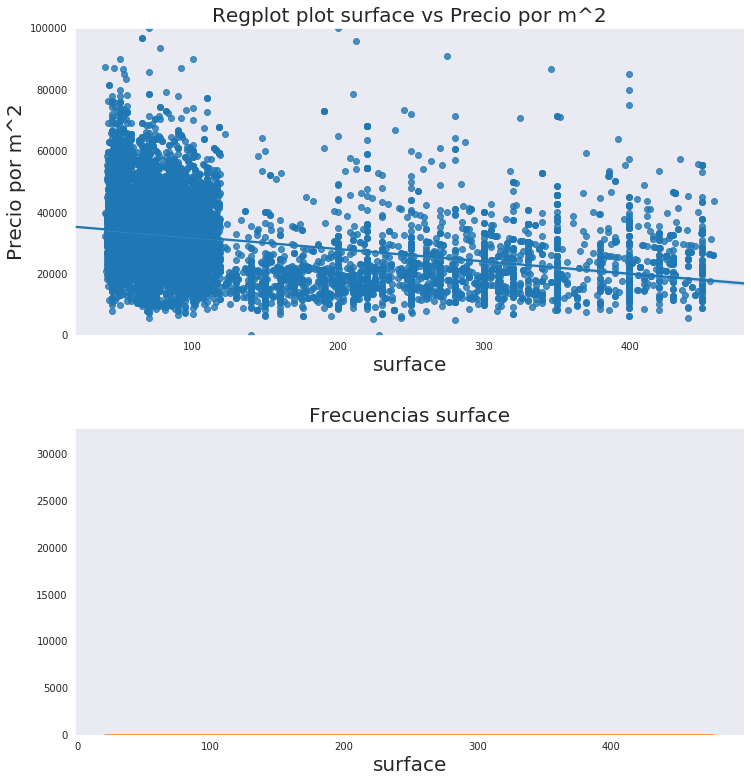

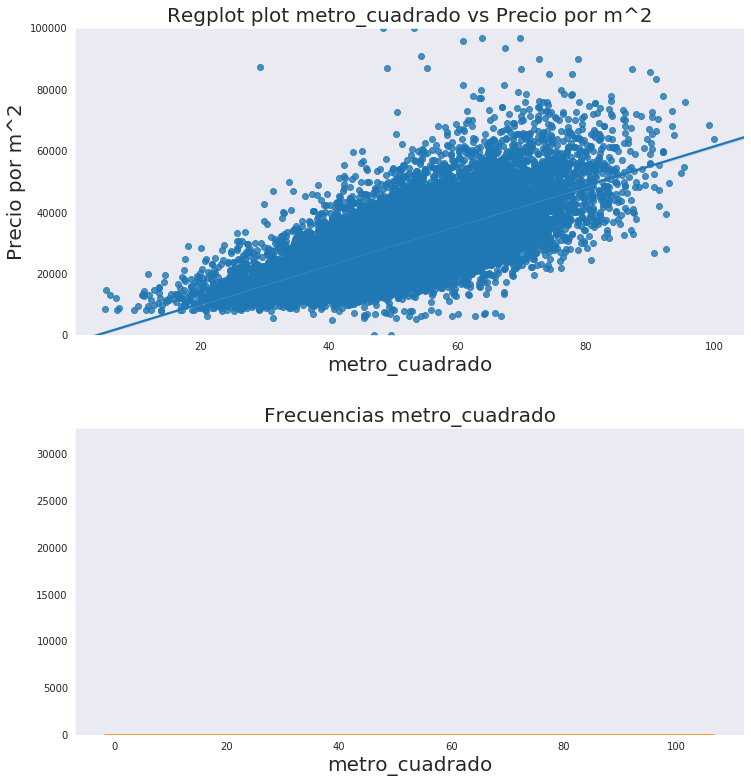

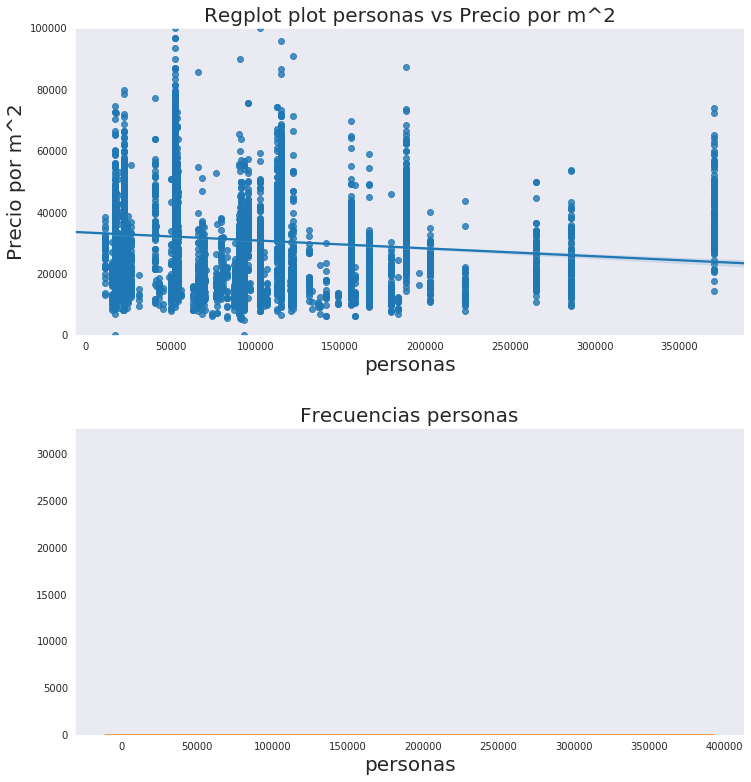

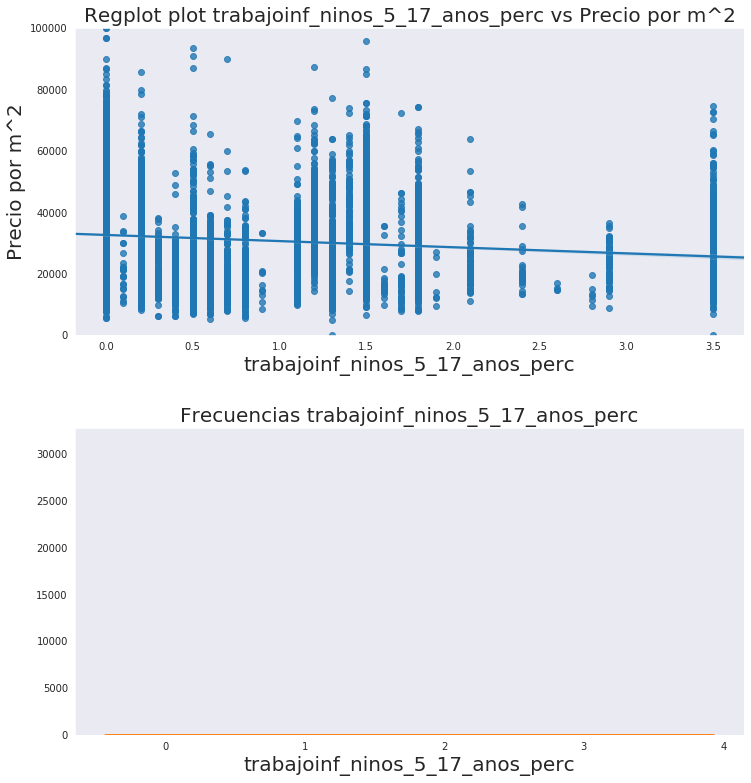

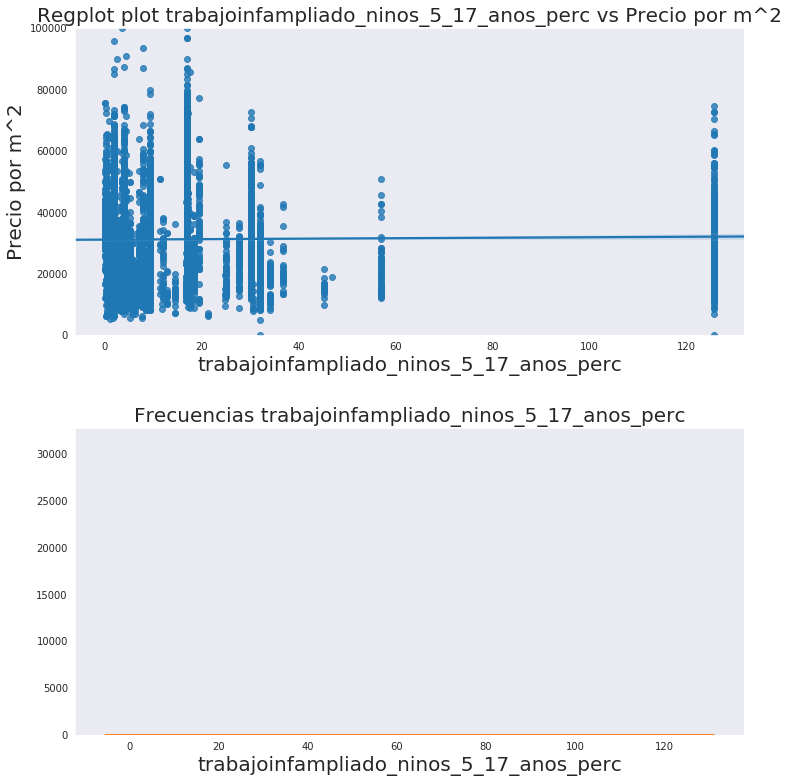

In [57]:
# scatter_dists('n_rooms')
# scatter_dists('n_bath')
scatter_dists('surface')
scatter_dists('metro_cuadrado')
# scatter_dists('n_garajes')
scatter_dists('personas')
scatter_dists('trabajoinf_ninos_5_17_anos_perc')
scatter_dists('trabajoinfampliado_ninos_5_17_anos_perc')

In [58]:
# Perfilamiento Bivariado
# Se genera una función auxiliar


def indexer(cols, t_c=df.columns):
    '''Genera columnas multinivel a partir de nombres de columna planos.'''

    set_to_tuple = set(*[cols])

    tuples = [
        i for i in t_c if set_to_tuple.intersection(set(i))
    ]
    return tuples


def perfil_bivariado(interest):
    # Variables a examinar
    idxs = indexer(interest)
    df[idxs].head()
    # Pone precio_m2 al final de la lista
    idxs.sort()
    idxs.remove(('numeric', 'precio_m2'))
    idxs.append(('numeric', 'precio_m2'))
    # para que Seaborn entienda
    data = df.reindex(idxs, axis=1).droplevel(0, axis=1)
    # quitar 100 datos con precio mas grande para poder visualizar mejor
    data.drop(data.precio_m2.nlargest(100).index)

    sns.pairplot(data=data, diag_kind='kde')

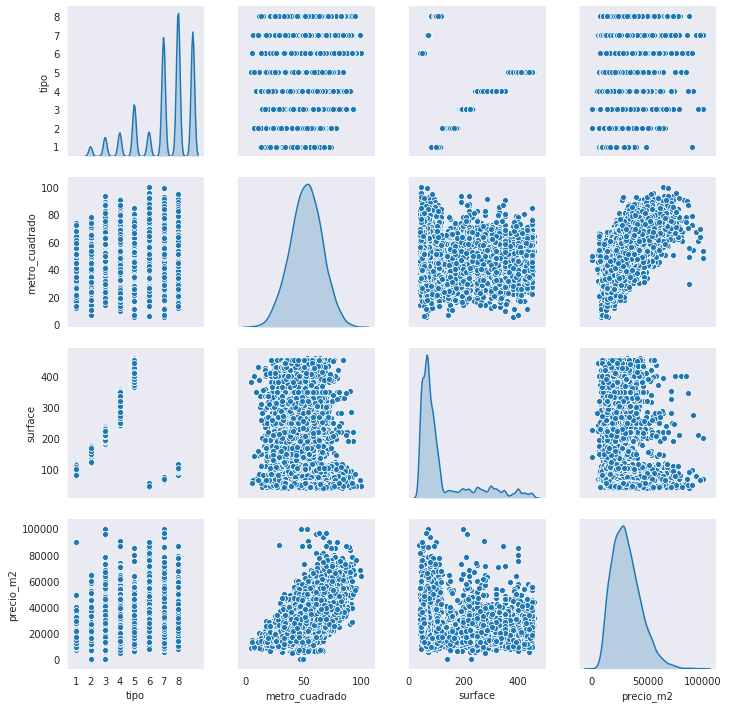

In [59]:
#interest1=['precio_m2', 'n_rooms', 'n_bath', 'surface', 'n_garajes','property_type', 'upz_group','tipo','metro_cuadrado']
interest1 = ['precio_m2', 'n_rooms', 'n_bath', 'surface',
             'n_garajes', 'property_type', 'tipo', 'metro_cuadrado']
perfil_bivariado(interest1)

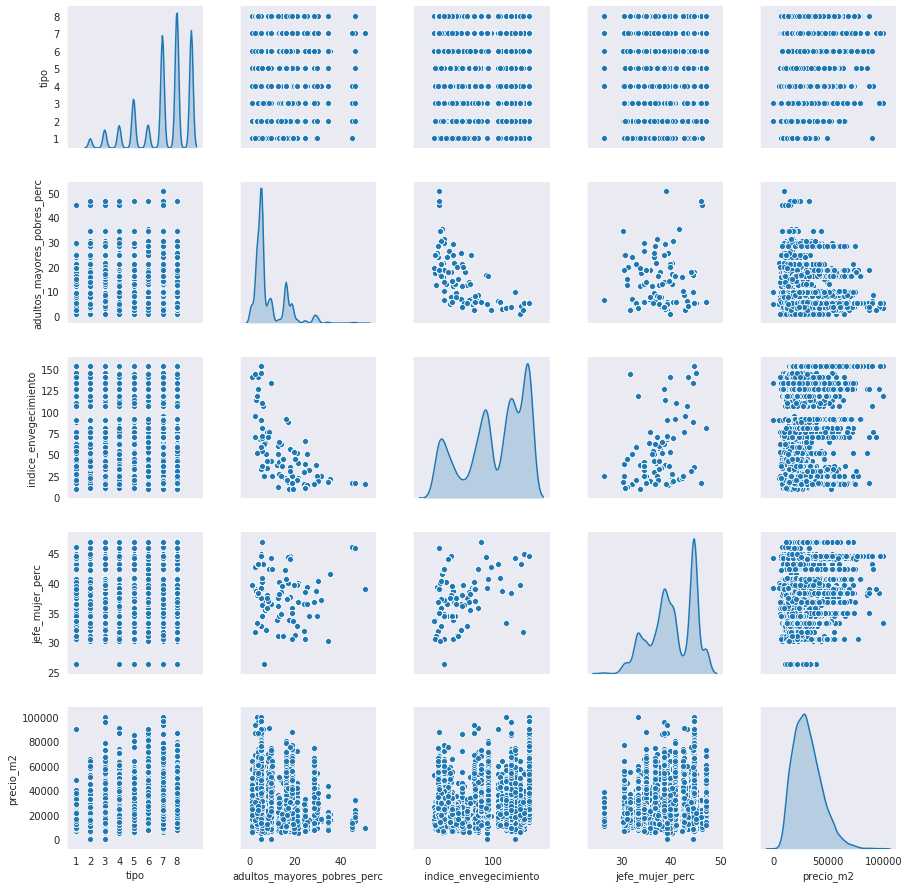

In [60]:
interest2 = ['precio_m2', 'jefe_mujer_perc',
             'indice_envegecimiento', 'adultos_mayores_pobres_perc', 'tipo']
perfil_bivariado(interest2)

10 variables más correlacionadas
                                                  numeric
                                                precio_m2
numeric precio_m2                                1.000000
        metro_cuadrado                           0.680506
        jefe_mujer_perc                          0.353681
        indice_envegecimiento                    0.306006
        price                                    0.239256
        trabajoinfampliado_ninos_5_17_anos_perc  0.014706
        indice_inseguridad                       0.005989
        UPlArea                                 -0.023939
        adultos_mayores_pobres_perc             -0.072353
        personas                                -0.122856
3 variables menos correlacionadas
                                       numeric
                                     precio_m2
numeric surface                      -0.307283
        dens_upz                     -0.178741
        jovenes_14_24_anos_nini_perc -0.157844


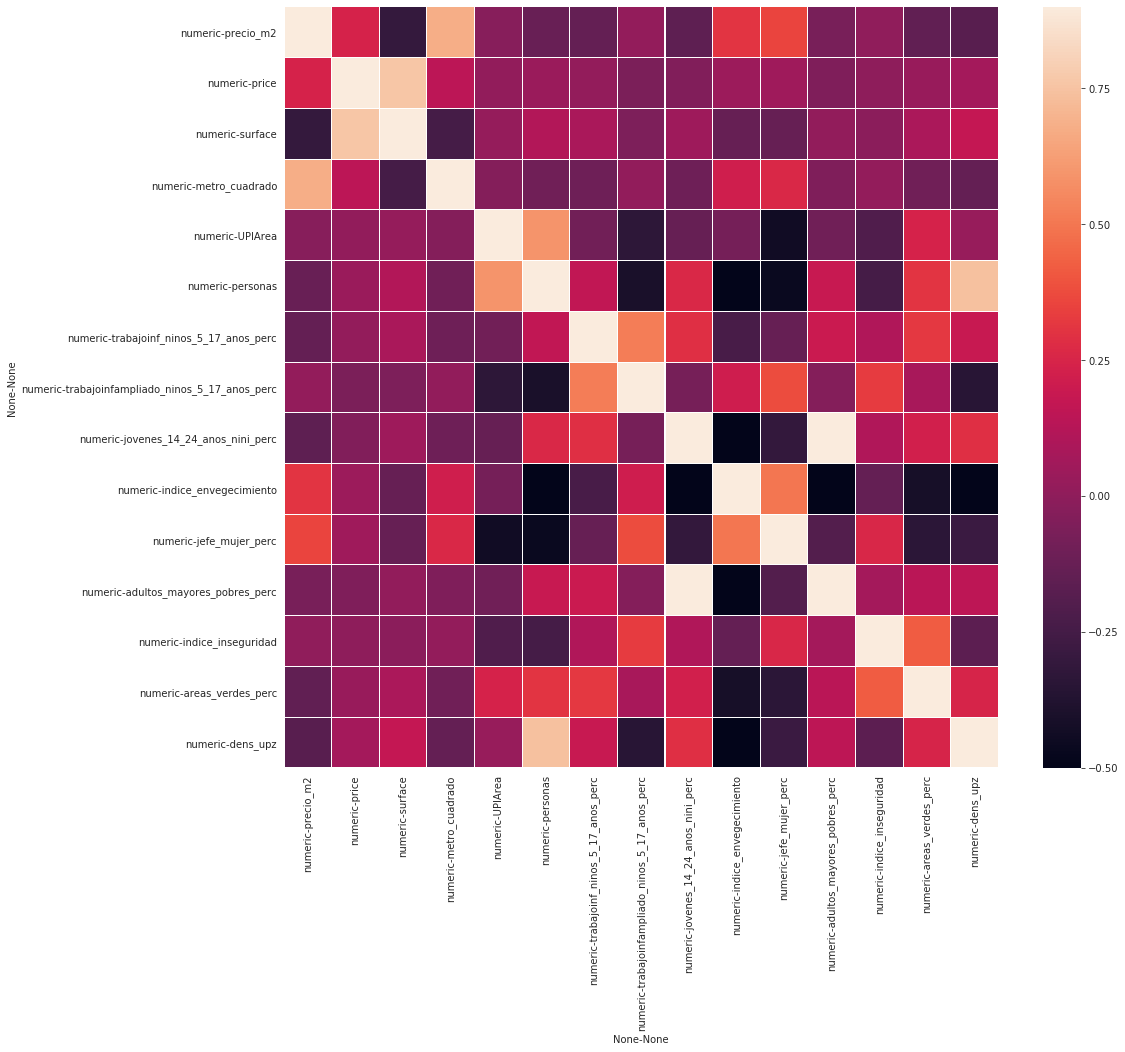

In [61]:
# matriz de correlaciones
corr_matrix = df.corr()
col = indexer(['precio_m2'])
print('10 variables más correlacionadas')
print(corr_matrix[col].nlargest(10, col))
print('3 variables menos correlacionadas')
print(corr_matrix[col].nsmallest(3, col))


# Visualizar

'''
Se inserta 'precio_m2' como primera fila x columna de la matriz de correlacion
'''

unsorted = list(corr_matrix.columns)
unsorted.remove(*col)
unsorted.insert(0, *col)

sortd = pd.MultiIndex.from_tuples(unsorted)
corrmat = corr_matrix.reindex(index=sortd, columns=sortd)
'''
Dado lo anterior, se ajusta el anchor de colores con maximo en .9
y -0.5, para tener una perspectiva entorno a los valores maximos 
de correlacion (negativa y positiva)
'''

fig, ax = plt.subplots(figsize=[16, 14])

sns.heatmap(corrmat, vmin=-.5, vmax=.9, linewidths=.01)

In [62]:
# analisis categórico versus categóricos

data_cat = df['categorical']


def categorical_compa(cat1, cat2):
    to_compare = [cat1, cat2]
    kwargs = {'index': data_cat[to_compare[0]],
              'columns': data_cat[to_compare[1]]}
    tabla = pd.crosstab(**kwargs, margins=True, margins_name='Total')
    return tabla

In [63]:
categorical_compa('rent_type', 'property_type')

property_type,Apartamento,Casa,Total
rent_type,,,
Arriendo,7345,2161,9506
Venta Y Arriendo,1080,641,1721
Total,8425,2802,11227


In [64]:
categorical_compa('rent_type', 'tipo')

tipo,1,2,3,4,5,6,7,8,Total
rent_type,,,,,,,,,
Arriendo,194,363,393,827,384,2333,2811,2201,9506
Venta Y Arriendo,12,57,117,308,147,241,392,447,1721
Total,206,420,510,1135,531,2574,3203,2648,11227


In [65]:
#categorical_compa('tipo', 'zona')

In [66]:
categorical_compa('upz_group', 'tipo')

tipo,1,2,3,4,5,6,7,8,Total
upz_group,,,,,,,,,
0.0,57,80,108,172,82,390,459,403,1751
1.0,145,334,386,921,436,1971,2625,2200,9018
2.0,4,6,16,42,13,213,119,45,458
Total,206,420,510,1135,531,2574,3203,2648,11227


In [67]:
# comparar con test xi^2
from scipy.stats import chi2_contingency


def test_xi(cat1, cat2):
    to_compare = [cat1, cat2]
    kwargs = {'index': data_cat[to_compare[0]],
              'columns': data_cat[to_compare[1]]}
    tabla = pd.crosstab(**kwargs, margins=False)
    chi2, p, dof, ex = chi2_contingency(tabla)
    expected_freq = pd.DataFrame(ex, index=df.categorical[cat1].unique())
    expected_freq.index.name = cat1
    expected_freq.columns.name = cat2
    return p, expected_freq


p, table = test_xi('upz_group', 'tipo')
print(p)
print(p <= 0.05)
table

1.6225683060356837e-37
True


tipo,0,1,2,3,4,5,6,7
upz_group,,,,,,,,
0.0,32.12844,65.504587,79.541284,177.018349,82.816514,401.449541,499.550459,412.990826
1.0,165.46789,337.361717,409.653514,911.679879,426.521600,2067.545382,2572.784715,2126.985303
2.0,8.40367,17.133696,20.805202,46.301773,21.661887,105.005077,130.664826,108.023871


In [68]:
p, table = test_xi('rent_type', 'tipo')
print(p)
print(p <= 0.05)
table

1.5118920977302235e-65
True


tipo,0,1,2,3,4,5,6,7
rent_type,,,,,,,,
Arriendo,174.422018,355.617707,431.821502,961.014519,449.602387,2179.428521,2712.008373,2242.084974
Venta Y Arriendo,31.577982,64.382293,78.178498,173.985481,81.397613,394.571479,490.991627,405.915026


# P3

### Implementación. 1

In [69]:
from sklearn.base import BaseEstimator, RegressorMixin
from numpy import matmul
from numpy.linalg import pinv, eig
import sys
import time
import numpy as np


class RegresionBayesianaEmpirica(BaseEstimator, RegressorMixin):
    def __init__(self, alpha_0, beta_0, tol=1e-5, maxiter=200):
        self.maxiter = maxiter
        self.tol = tol
        self.alpha_0 = alpha_0
        self.beta_0 = beta_0
        self.alpha = alpha_0
        self.beta = beta_0
        self.M_n = None
        self.S_n = None

    def get_posteriori(self, X, y, alpha, beta):

        S_n = alpha + beta*matmul(X.T, X)
        M_n = beta * matmul(matmul(pinv(S_n), X.T), y)
        return M_n, S_n

    def fit(self, X, y):
        X = np.hstack((np.ones((1, X.shape[0])).T, X))
        N = len(y)
        for i in range(self.maxiter):
            t0 = time.time()
            eigen_values, _ = eig(self.beta * matmul(X.T, X))
            eigen_values = np.real_if_close(eigen_values)
            gamma = (eigen_values/(self.alpha + eigen_values)).sum()
            M_n, S_n = self.get_posteriori(X, y, self.alpha, self.beta)
            new_alpha = gamma/(matmul(M_n.T, M_n))
            new_beta = (N-gamma)/((y - matmul(M_n.T, X.T))
                                  ** 2).sum()  # Revisar X.T

            alpha_delta = np.abs(self.alpha - new_alpha)
            beta_delta = np.abs(self.beta - new_beta)

            sys.stdout.write(
                '\rIteracion:{0:03d} '.format(
                    i+1) + '| Alpha :{0:.5f} '.format(new_alpha)
                + '| Beta :{0:.5f} '.format(new_beta)
                + '| Tiempo/iter:{0:.5f}s'.format(time.time() - t0)
            )

            if (alpha_delta > self.tol or beta_delta > self.tol):
                self.alpha = new_alpha
                self.beta = new_beta
            else:
                self.M_n = M_n
                self.S_n = S_n
                break
        self.M_n = M_n
        self.S_n = S_n

    # Predicción utilizando la media posterior predictiva
    def predict(self, X_, return_std=False):
        X_ = np.hstack((np.ones((1, X_.shape[0])).T, X_))
        mu = matmul(self.M_n.T, X_.T)
        if return_std:
            std = np.sqrt(self.beta**-1 + matmul(matmul(X_.T, self.S_n), X_))
            return mu, std
        else:
            return mu

In [70]:
numeric = [tupla[1] for tupla in df.columns
           if tupla[0] == 'numeric' and
           tupla[1] != 'precio_m2' and tupla[1]!= 'price']

categorical = [tupla[1] for tupla in df.columns
               if tupla[0] == 'categorical'
               and tupla[1] != '_merge'
               and tupla[1] != 'url'
               and tupla[1] != 'location'
               and tupla[1] != 'details'
               and tupla[1] != 'upz_cluster']

In [71]:
numeric

['surface',
 'metro_cuadrado',
 'UPlArea',
 'personas',
 'trabajoinf_ninos_5_17_anos_perc',
 'trabajoinfampliado_ninos_5_17_anos_perc',
 'jovenes_14_24_anos_nini_perc',
 'indice_envegecimiento',
 'jefe_mujer_perc',
 'adultos_mayores_pobres_perc',
 'indice_inseguridad',
 'areas_verdes_perc',
 'dens_upz']

In [72]:
categorical

['n_garajes',
 'rent_type',
 'upz',
 'n_bath',
 'property_type',
 'n_rooms',
 'tipo',
 'upz_group']

In [73]:
X = df.reindex(df.columns, axis=1).droplevel(0, axis=1)
y = df['numeric']['precio_m2']

In [74]:
from sklearn.model_selection import train_test_split
seed = 3891624866
seed = 0

np.random.seed(seed)
X_train, X_test, y_train, y_test = train_test_split(
    X, np.array(y), test_size=0.2)

In [75]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer


numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer()),
                                      #('StandarScaler', StandardScaler()),
                                      ('MinMaxScaler', MinMaxScaler()),
                                      ('PolynomialFeatures', PolynomialFeatures(degree=3))])


categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='Nan')),
                                          ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))])

preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric),
                                               ('cat', categorical_transformer, categorical)])


regressor = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', RegresionBayesianaEmpirica(
                                alpha_0=1e-8, beta_0=1e-8, tol=1e-14, maxiter=300))])


regressor.fit(X_train, y_train)

Iteracion:005 | Alpha :0.00000 | Beta :0.00000 | Tiempo/iter:0.50247s

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='mean',
                                                               

In [76]:
from sklearn.metrics import r2_score, mean_squared_error

Y_pred = regressor.predict(X_test)
r2 = r2_score(y_test, Y_pred)
rmse = mean_squared_error(y_test, Y_pred)
print('   RMSE: {0:.3f}'.format(rmse))
print('R2Score: {0:.3f}'.format(r2))

   RMSE: 69093184.596
R2Score: 0.558


Guardamos el modelo

In [77]:
import pickle
filename = '0445.sav'
#pickle.dump(regressor, open(filename, 'wb'))

In [78]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_train, y_train)
print(result)

/home/jipi/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator SimpleImputer from version 0.22.1 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


ModuleNotFoundError: No module named 'sklearn.preprocessing._data'

Bayesian Ridge regression

In [ ]:
from sklearn.linear_model import BayesianRidge
c = 1e-08

bayesian_ridge_regressor = Pipeline(steps=[('preprocessor', preprocessor),
                                           ('classifier', BayesianRidge(alpha_1=c,
                                                                        alpha_2=c,
                                                                        lambda_1=c,
                                                                        lambda_2=c))])
bayesian_ridge_regressor.fit(X_train, y_train)

In [ ]:
Y_pred = bayesian_ridge_regressor.predict(X_test)
r2 = r2_score(y_test, Y_pred)
rmse = mean_squared_error(y_test, Y_pred)
print('   RMSE: {0:.3f}'.format(rmse))
print('R2Score: {0:.3f}'.format(r2))